In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import qcnn as q

In [2]:
## read / import data 
num_qubits = 8
training_fname = "example_training_data_n8.txt"
test_fname = "example_test_data_n8.txt"

def read_eigenvectors(file):
    with open(file, 'r+') as f:
        textData = f.readlines()

        h_vals = []
        for i in range(len(textData)):
            h1h2, eigenvector = textData[i].split("_")

            h_vals.append(tuple(map(float, h1h2[1: -1].split(', '))))
            textData[i] = eigenvector

        return h_vals, np.loadtxt(textData, dtype=complex)

h1h2_train, train_data = read_eigenvectors(training_fname)
h1h2_test, test_data = read_eigenvectors(test_fname)

labels = np.zeros(40)

for index, h1h2 in enumerate(h1h2_train):
    h1, h2 = h1h2
    if h1 <= 1: 
        labels[index] = 1.0

# for h1h2, label in zip(h1h2_train, labels):
#     print(h1h2, label)


In [3]:
## Model 
my_qcnn = q.Qcnn(num_qubits)

## def structure: 
conv4_kwargs = {"label":"C4_1"} 
first_conv_kwargs = {"label": "C2"}
second_conv_kwargs = {"label": "C3", 
                      "start_index": 1}
third_conv_kwargs = {"label": "C4", 
                     "start_index": 2}
pool_kwargs = {"label": "P1", 
               "update_active_qubits": {"group_len": 3, "target": 1}}

my_qcnn.add_layer(my_qcnn.Layers["legacy_conv4_layer"], conv4_kwargs)
# my_qcnn.add_layer(my_qcnn.Layers["legacy_conv4_layer"], conv4_kwargs)
# my_qcnn.add_layer(my_qcnn.Layers["legacy_conv_layer"], first_conv_kwargs)
# my_qcnn.add_layer(my_qcnn.Layers["legacy_conv_layer"], second_conv_kwargs)
# my_qcnn.add_layer(my_qcnn.Layers["legacy_conv_layer"], third_conv_kwargs)
my_qcnn.add_layer(my_qcnn.Layers["legacy_pool_layer"], pool_kwargs)

my_qcnn.initialize_params(random=True)

## visual check : 
# circ = my_qcnn.generate_circ()
# circ.draw(reverse_bits=True)

### Learning as described in paper: 

In [5]:
## Learning as described in paper: 
learning_rate = 10
successive_loss = 1.0 # initialize to arbitrary value > 10^-5
loss_lst = []  # initialize 
iteration_num = 1 

while (abs(successive_loss) > 1e-5) and (iteration_num < 1000):
    pred = my_qcnn.forward(train_data, my_qcnn.params.copy())
    loss = my_qcnn.mse_loss(pred, labels)
    
    print("---- Iteration : {}, Loss {} ----------------------".format(iteration_num, loss))
    
    if iteration_num == 1:
        pass 
    
    else: 
        successive_loss = loss - loss_lst[-1]       
        if successive_loss < 0: 
            learning_rate *= 1.05  # if loss decreases, increase learning rate by 5%
        else:
            learning_rate /= 2  # if it gets bigger, decrease learning rate by 50% 
            
    grad_mat = my_qcnn.compute_grad(train_data, labels)
    my_qcnn.update_params(grad_mat, learning_rate)
    
    loss_lst.append(loss)
    iteration_num += 1 
    
params = my_qcnn.params


---- Iteration : 1, Loss 0.5635534446137898 ----------------------


ValueError: operands could not be broadcast together with shapes (2,3) (2,) (2,3) 

In [6]:
# print(params)  ## extracting parameters to save future training time 

In [8]:
## Using model on test data (graph visualization) :
predictions = my_qcnn.forward(test_data, my_qcnn.params.copy())
print('got predictions!')

got predictions!


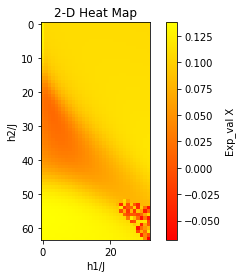

In [9]:
flipped_pred_mat = predictions.reshape((64, 32), order='F')
pred_mat = []
for row_index in np.arange(len(flipped_pred_mat) - 1, -1, -1):
    pred_mat.append(flipped_pred_mat[row_index])

pred_mat = np.array(pred_mat)

heat_map = plt.imshow(pred_mat, cmap = 'autumn', interpolation = 'nearest')
plt.colorbar(heat_map, label="Exp_val X")
plt.title( "2-D Heat Map" )
plt.xlabel('h1/J')
plt.ylabel('h2/J')
plt.show()

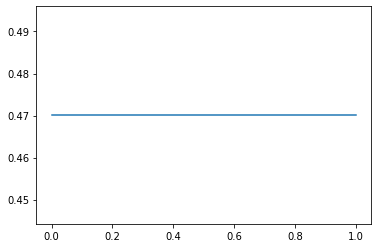

In [8]:
## Loss plot: 
x_axis = range(len(loss_lst))

plt.plot(x_axis, loss_lst)
plt.show()

### Experimental Learning Approach: 

In [ ]:
## Experimental Learning approach: 
num_epoches = 100
batch_size = 10
learning_rate = 10


### Helper function for testing internal tools

In [20]:
from qiskit import quantum_info as qi
from qiskit import QuantumCircuit
num_qubits = 3

random_state = qi.random_statevector(2**num_qubits)
state_vector = random_state.data  # the actual vector of a1, a2, ... , a2^n

# technical note, the probabilities are actually given by (ai)^2 
state_vector = np.array(state_vector)
probability_vector = (np.abs(state_vector))**2    # this is what you use to compute your expectation value ! 

# sanity check : 
# print(state_vector) # can be real or imaginary 
# print(probability_vector) # all real 
# print(np.sum(probability_vector)) # must be 1 


def middle_qubit_exp_value(state_vect, num_qubits):
    middle_qubit_index = num_qubits // 2

    operator_circ = QuantumCircuit(num_qubits)          # define the circuit for the operator we want to computer
    operator_circ.x(middle_qubit_index)                 # expectation value for
    operator_circ = operator_circ.reverse_bits()

    operator = qi.Operator(operator_circ)               # operator of interest
    exp_value = state_vect.expectation_value(operator)  # expectation value of X operator on middle qubit

    return exp_value

## Your Exp should match this value: 
exp_val = middle_qubit_exp_value(random_state, num_qubits)
print(exp_val)

(0.09406795455625483+0j)
